In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [7]:
mixDataSets = torch.load("/root/mix-rawDatasets-2.pt") # shape: 26447*150540(11+3*224*224+1)
mixDataSets = mixDataSets.to(dtype=torch.float32) # 内存

In [8]:
mixDataSets = mixDataSets[torch.randperm(mixDataSets.size()[0])] #shuffle,而且是有label的

In [9]:
from torchvision import transforms

trainingRatio = 0.8
batchSize=128
device = torch.device("cpu")

tranforms = transforms.Normalize(0,1)

rawTensorDataSets = mixDataSets

rawTensorDataSetsData = rawTensorDataSets[:,0:-1].to(dtype=torch.float32).to(device)
rawTensorDataSetsLabel = rawTensorDataSets[:,-1].to(dtype=torch.float32).to(device)

totalCount = rawTensorDataSets.shape[0] # must be 26447
trainingCount = int(totalCount * trainingRatio)

trainingData = rawTensorDataSets[0:trainingCount, 0:-1].to(dtype=torch.float32).to(device)
trainingLabel = rawTensorDataSets[0:trainingCount, -1].to(dtype=torch.long).to(device)
validatingData = rawTensorDataSets[trainingCount:, 0:-1].to(dtype=torch.float32).to(device)
validatingLabel = rawTensorDataSets[trainingCount:, -1].to(dtype=torch.long).to(device)

In [5]:
def normalize(tensor): # find mean and std of R/G/B
    mean=torch.mean(tensor)
    std=torch.std(tensor)
    return mean,std

In [6]:
sensor = rawTensorDataSetsData[:,0:11] #已经归一化了，现在对R/G/B三个图像通道归一化
R = rawTensorDataSetsData[:,11:11+224*224]
G = rawTensorDataSetsData[:,11+224*224:11+2*224*224]
B = rawTensorDataSetsData[:,11+2*224*224:11+3*224*224]

Rmean,Rstd = normalize(R)
Gmean,Gstd = normalize(G)
Bmean,Bstd = normalize(B)
torch.save(Rmean,"Rmean.pt");torch.save(Rstd,"Rstd.pt")
torch.save(Gmean,"Gmean.pt");torch.save(Gstd,"Gstd.pt")
torch.save(Bmean,"Bmean.pt");torch.save(Bstd,"Bstd.pt")


In [12]:
def real_normalize(tensor,mean,std):
    tensor = (tensor-mean)/std
    return tensor

In [13]:
# 原始数据
sensor_train = trainingData[:,0:11]
R_train = trainingData[:,11:11+224*224]
G_train = trainingData[:,11+224*224:11+2*224*224]
B_train = trainingData[:,11+2*224*224:11+3*224*224]
# 归一化
R_train = real_normalize(R_train,Rmean,Rstd)
G_train = real_normalize(G_train,Gmean,Gstd)
B_train = real_normalize(B_train,Bmean,Bstd)
# 拼接
nor_trainingData = torch.concat((sensor_train,R_train,G_train,B_train),dim=-1)
print(nor_trainingData.shape)

torch.Size([21157, 150539])


In [15]:
# 原始数据
sensor_test = validatingData[:,0:11]
R_test = validatingData[:,11:11+224*224]
G_test = validatingData[:,11+224*224:11+2*224*224]
B_test = validatingData[:,11+2*224*224:11+3*224*224]
# 归一化
R_test = real_normalize(R_test,Rmean,Rstd)
G_test = real_normalize(G_test,Gmean,Gstd)
B_test = real_normalize(B_test,Bmean,Bstd)
# 拼接
nor_validatingData = torch.concat((sensor_test,R_test,G_test,B_test),dim=-1)
print(nor_validatingData.shape)

torch.Size([5290, 150539])


In [9]:
'''
sensor = trainingData[:,0:11]
R = trainingData[:,11:11+224*224]
G = trainingData[:,11+224*224:11+2*224*224]
B = trainingData[:,11+2*224*224:11+3*224*224]
R = normalize(R) ; G = normalize(G) ; B = normalize(B)
trainingData = torch.concat((sensor,R,G,B),dim=-1)
print(trainingData.shape)
'''

'\nsensor = trainingData[:,0:11]\nR = trainingData[:,11:11+224*224]\nG = trainingData[:,11+224*224:11+2*224*224]\nB = trainingData[:,11+2*224*224:11+3*224*224]\nR = normalize(R) ; G = normalize(G) ; B = normalize(B)\ntrainingData = torch.concat((sensor,R,G,B),dim=-1)\nprint(trainingData.shape)\n'

In [9]:
'''
sensor = validatingData[:,0:11]
R = validatingData[:,11:11+224*224]
G = validatingData[:,11+224*224:11+2*224*224]
B = validatingData[:,11+2*224*224:11+3*224*224]
R = normalize(R) ; G = normalize(G) ; B = normalize(B)
validatingData = torch.concat((sensor,R,G,B),dim=-1)
print(validatingData.shape)
'''

torch.Size([5290, 150539])


In [19]:
trainingDataSet = TensorDataset(nor_trainingData, trainingLabel)
validatingDataSet = TensorDataset(nor_validatingData, validatingLabel)

train_dataloader = DataLoader(trainingDataSet, batch_size=batchSize, shuffle=True)
val_dataloader = DataLoader(validatingDataSet, batch_size=batchSize, shuffle=True)

In [2]:
# resnet-18 

import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, identity_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        #这里定义了残差块内连续的2个卷积层
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # if identity_downsample is not None as default, then:
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = x + identity
        x = self.relu(x)
        
        return x

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class model_mix(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(model_mix, self).__init__()
        
        # self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # fc
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=21,out_features=256,bias=True), # 20+5 / 20+11
                nn.Dropout(p = 0.2),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                nn.Linear(in_features=256,out_features=128,bias=True),
                nn.ReLU())
        self.hidden3=nn.Sequential(
                nn.Linear(in_features=128,out_features=100,bias=True),
                nn.ReLU())
        self.hidden4=nn.Sequential(
                nn.Linear(in_features=100,out_features=10,bias=True),
                nn.ReLU())

        
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )  
    
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None #默认是none,即identity-free shortcut
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        #对于64-128.128-256.256-512的第一个block,有stride=2,且outchannel=2*inchannel；
        #其他的block,64-64的全部2个,64-128的第2个，128-256的第2个，256-512的第2个，都是outchannel=inchannel
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        x1 = x[:,11:] ; x2=x[:,0:11]
        x1 = x1.reshape((-1, 3, 224, 224))
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.maxpool(x1)
        
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = self.layer3(x1)
        x1 = self.layer4(x1)
        
        x1 = self.avgpool(x1)
        x1 = x1.view(x1.shape[0], -1)
        x1 = self.fc(x1)
        
        x = torch.concat((x1,x2),dim=-1)
        
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
        output=self.hidden4(x)
        
        return output
    

In [22]:
device = torch.device("cuda")
model = model_mix(3,10).to(device)

Epoch 1, Average Training Loss: 186.7431, Training Accuracy: 63.0241%, Validating Accuracy: 89.5085%
Epoch 2, Average Training Loss: 38.7734, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 3, Average Training Loss: 37.4681, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 4, Average Training Loss: 37.3912, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 5, Average Training Loss: 37.4019, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 6, Average Training Loss: 37.3602, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 7, Average Training Loss: 37.4347, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 8, Average Training Loss: 37.2496, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 9, Average Training Loss: 37.2904, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085%
Epoch 10, Average Training Loss: 37.2855, Training Accuracy: 90.2538%, Validating Accuracy: 89.5085

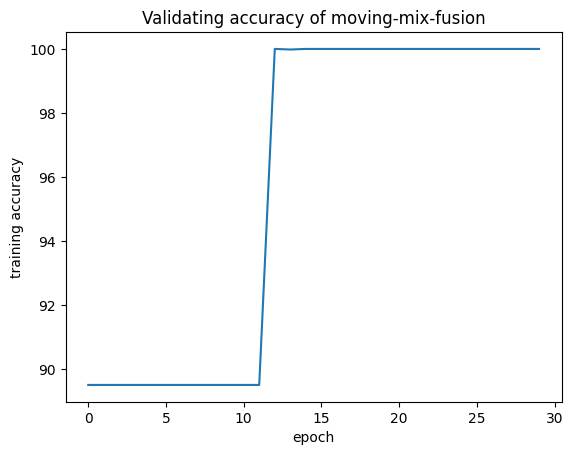

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

acc_val=[]

total_epoch=30
device = torch.device("cuda")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

iterr=[]
for i in range(total_epoch):
    iterr.append(i)

for epoch in range(total_epoch):
    statisticLoss = 0.0
    total = 0
    correct = 0

    # Training
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()  
        
        features = features.to(device)
        labels=labels.to(device)
        
        output = model(features)

        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()

        statisticLoss += loss.item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    trainingAcc = 100 * correct / total
    
    
    # Validating
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (features, labels) in enumerate(val_dataloader):
            features = features.to(device)
            labels=labels.to(device)
        
            output = model(features)

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    validatingAcc = 100 * correct / total
    
    acc_val.append(validatingAcc)

    print("Epoch %d, Average Training Loss: %.4lf, Training Accuracy: %.4lf%%, Validating Accuracy: %.4lf%%" %(epoch+1, statisticLoss, trainingAcc, validatingAcc))
    
torch.save(model, "/root/moving_fusion_architecture.pth")

plt.figure()
plt.plot(iterr,acc_val)
plt.title('Validating accuracy of moving-mix-fusion')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.savefig('moving-mix-fusion2.png')
plt.show()

In [14]:
import torch
device=torch.device("cuda")
val_model = torch.load("moving_fusion_architecture.pth").to(device)

In [15]:
Rmean=torch.load("Rmean.pt"); Rstd=torch.load("Rstd.pt")
Gmean=torch.load("Gmean.pt"); Gstd=torch.load("Gstd.pt")
Bmean=torch.load("Bmean.pt"); Bstd=torch.load("Bstd.pt")

In [18]:
test = trainingData[10]
label = trainingLabel[10].to("cuda")

with torch.no_grad():
    sensor=tmp[0:11]
    R=test[11:11+224*224]
    G=test[11+224*224:11+2*224*224]
    B=test[11+2*224*224:11+3*224*224]
    R=(R-Rmean)/Rstd
    G=(G-Gmean)/Gstd
    B=(B-Bmean)/Bstd
    new_test=torch.concat((sensor,R,G,B),dim=-1).to(device="cuda")
    
    output = val_model(new_test)
    print(output)
    
    

IndexError: too many indices for tensor of dimension 1